In [1]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,mean_squared_error,accuracy_score, f1_score
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, seaborn as sns

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("july/first_week/feat_ext64_mpu1.csv")
data.dtypes.value_counts()
Class = pd.read_csv("july/first_week/Ymotion_resize64_fe_mpu1.csv")
print(data.shape,Class.shape)

(202, 114) (202, 1)


In [4]:
# Load the iris dataset (as an example)
y, X = Class, data

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_test.value_counts()

Class
5.0      15
3.0      13
2.0      12
4.0      11
1.0      10
Name: count, dtype: int64

In [13]:
mean_Xtrain = X_train.mean()
std_Xtrain = X_train.std()

zscores_Xtrain = (X_train - mean_Xtrain)/std_Xtrain
zscores_Xtest = (X_test - mean_Xtrain)/std_Xtrain

In [10]:
from sklearn.model_selection import KFold

# 10-fold Cross falidation
# Define the number of folds
n_splits = 10

# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a list to store the mean squared error for each fold
mse_list = []
Accuracy_list = []
F1_list = []

# Loop over the folds
for train_index, test_index in kf.split(X):
    
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize z-score
    mean_Xtrain = X_train.mean()
    std_Xtrain = X_train.std()

    zscores_Xtrain = (X_train - mean_Xtrain)/std_Xtrain
    zscores_Xtest = (X_test - mean_Xtrain)/std_Xtrain
    
    # Train your model on the training set
    model = SVC(kernel='linear', C=10, decision_function_shape='ovr')
    model.fit(zscores_Xtrain, y_train)
    
    # Test your model on the testing set
    y_pred = model.predict(zscores_Xtest)
    
    # Calculate the mean squared error and append it to the mse_list
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    
    # Calculate the Accuracy
    Accuracy_list.append(accuracy_score(y_test, y_pred))
    
    # Calculate the F1 Score
    F1_list.append(f1_score(y_test, y_pred, average='macro'))

# Calculate the mean and standard deviation of the mean squared error across all folds
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)


mean_Accu_scr = round(np.mean(Accuracy_list),2)
std_Accu_scr = round(np.std(Accuracy_list),2)

mean_f1 = round(np.mean(F1_list),2)
std_f1 = round(np.std(F1_list),2)

In [11]:
print(f"Mean squared error: {mean_mse:.2f} +/- {std_mse:.2f}")
print(f"Accuracy score: {mean_Accu_scr:.2f} +/- {std_Accu_scr:.2f}")
print(f"F1 score: {mean_f1:.2f} +/- {std_f1:.2f}")

Mean squared error: 0.30 +/- 0.37
Accuracy score: 0.94 +/- 0.07
F1 score: 0.95 +/- 0.07


In [14]:
# Create an SVM classifier with a linear kernel
svm = SVC(kernel='linear', C=10, decision_function_shape='ovr')

# Train the classifier on the training data
svm.fit(zscores_Xtrain, y_train)

# Predict the labels of the test set
y_pred = svm.predict(zscores_Xtest)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.90      0.90      0.90        10
         2.0       0.91      0.83      0.87        12
         3.0       0.93      1.00      0.96        13
         4.0       0.90      0.82      0.86        11
         5.0       0.94      1.00      0.97        15

    accuracy                           0.92        61
   macro avg       0.92      0.91      0.91        61
weighted avg       0.92      0.92      0.92        61



Text(0.5, 36.72222222222221, 'Ground Truth')

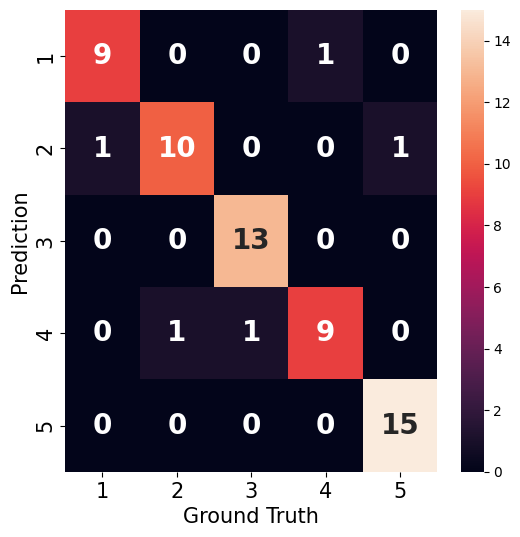

In [15]:
# Plot confusion matrix
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['1','2','3','4','5']
ax.set_xticklabels(labels, fontsize=15);
ax.set_yticklabels(labels, fontsize=15);
ax.set_ylabel('Prediction', fontsize=15);
ax.set_xlabel('Ground Truth', fontsize=15)

In [16]:
# Define the SVM classifier
svm = SVC()

# Define the parameter grid for C
param_grid = {'C': [1, 8, 10, 100]}

# Define the grid search with 10-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10)

# Perform the grid search
grid_search.fit(X, y)

# Get the results for each value of C
results = grid_search.cv_results_

# Print the accuracy and F1 score for each value of C
for mean_score, params in zip(results['mean_test_score'], results['params']):
    c_value = params['C']
    svm = SVC(C=c_value)
    scores = cross_val_score(svm, X, y, cv=10)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Normalize z-scores
    mean_Xtrain = X_train.mean()
    std_Xtrain = X_train.std()

    zscores_Xtrain = (X_train - mean_Xtrain)/std_Xtrain
    zscores_Xtest = (X_test - mean_Xtrain)/std_Xtrain
    
    accuracy = accuracy_score(y_test, svm.fit(zscores_Xtrain, y_train).predict(zscores_Xtest))
    f1 = f1_score(y_test, svm.fit(zscores_Xtrain, y_train).predict(zscores_Xtest), average='weighted')
    print("C =", c_value)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print()

C = 1
Accuracy: 0.8536585365853658
F1 Score: 0.8476989294779824

C = 8
Accuracy: 0.8780487804878049
F1 Score: 0.8751180271983715

C = 10
Accuracy: 0.8780487804878049
F1 Score: 0.8751180271983715

C = 100
Accuracy: 0.8780487804878049
F1 Score: 0.8751180271983715

